In [ ]:
import pandas as pd
import numpy as np
from my_pysyncon import Dataprep, Synth

In [2]:
# import the data

df_mo = pd.read_csv('../../../SharedData/total_state_data.csv')

In [3]:
# this list is used to make certain columns later

abbreviations = [
    "AL", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
    "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
    "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
]

In [ ]:
# add a bunch of features (these will eventually get moved to combine_files.ipynb)

df_mo['co2_per_capita'] = df_mo['monthly_emissions'] / df_mo['monthly_population']
df_mo['gdp_per_capita'] = df_mo['gdp_rel_2017_interp'] / df_mo['monthly_population']
df_mo['eprod_per_capita'] = df_mo['monthly_energy_prod'] / df_mo['monthly_population']
df_mo['euse_per_capita'] = df_mo['monthly_energy_use'] / df_mo['monthly_population']

# create column for simple moving avg of co2_per_capita; ma_window is the moving average window size (n=1 corresponds to usual monthly results)

df_mo['co2_per_capita_sma']= np.nan
ma_window = 12

for state in abbreviations:
    df_mo.loc[df_mo.state==state,'co2_per_capita_sma'] = df_mo.loc[df_mo.state==state,'co2_per_capita'].rolling(window=ma_window).mean()

In [5]:
treatment_date = '2009-01-01'
preintervention_ma_start_date = str((pd.to_datetime('1997-01-01')+ pd.DateOffset(months=ma_window-1)).strftime('%Y-%m-%d'))

preintervention_ma_range = df_mo.date[(df_mo.date >= preintervention_ma_start_date) & (df_mo.date<treatment_date)&(df_mo.state=='IN')]

# these are the dates used for our monthly_emissions SMA graph
years_sma = pd.date_range(start=preintervention_ma_start_date, end='2019-12-01', freq='MS').strftime('%Y-%m-%d').tolist()

In [7]:
# we leave off RGGI states;
# states with no CO2 data (AK, HI);
# states with some type of emissions program (CA, WA, OR, MN);
# and states with very high CO2 per capita (WY, ND, WV, LA)

rggi_states = ['CT', 'DE', 'ME', 'MD', 'MA', 'NH', 'NJ', 'NY', 'RI', 'VT', 'VA']

non_rggi_controls_identifier= [
    "AL", 
    #"AK", 
    "AZ", "AR", 
    #"CA", 
    "CO", 
    #"CT", 
    #"DE", 
    "FL", 
    "GA",
    #"HI", 
    "ID", "IL", "IN", "IA", "KS", "KY", 
    #"LA", 
    #"ME", 
    #"MD",
    #"MA", 
    "MI", 
    #"MN", 
    "MS", "MO", "MT", "NE", "NV", 
    #"NH", 
    #"NJ",
    "NM", "NC", 
    #"ND", 
    #"NY",
    "OH", "OK", 
    #"OR", 
    "PA", 
    #"RI", 
    "SC", "SD", "TN", 
    "TX", 
    "UT", 
    #"VT", 
    #"VA", 
    #"WA", 
    #"WV", 
    "WI", 
    #"WY"
    ]

In [8]:
# we create a synthetic control Delaware as applied to monthly_emissions SMA data

dataprep_mo_ma = Dataprep(
    foo=df_mo,
    predictors=['co2_per_capita_sma'],
    predictors_op="mean",
    time_predictors_prior=preintervention_ma_range,
    #special_predictors=[
        #('monthly_num_plants', preintervention_feature_range, "max"),
        #('eprod_per_capita', preintervention_energy_range, "mean"),
        #('eflow_per_capita', preintervention_energy_range, "mean"),
        #('gdp_per_capita', preintervention_gdp_range, "mean"),
        #('monthly_pop_density', preintervention_per_capita_range, "mean"),
        #('yearly_renew_pct', preintervention_energy_range, "mean"),
        #('yearly_fossil_pct', preintervention_energy_range, "mean")
        #],
    dependent="co2_per_capita_sma",
    unit_variable="state",
    time_variable="date",
    treatment_identifier="NY",
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=preintervention_ma_range
    )

In [9]:
# monthly_emissions SMA version

synth_mo_ma = Synth()
synth_mo_ma.fit(dataprep=dataprep_mo_ma, optim_initial='equal')
print(synth_mo_ma.weights(threshold=.01))

print('The pre-treatment fit loss is:', synth_mo_ma.loss_V)


ID    0.799
Name: weights, dtype: float64
The pre-treatment fit loss is: 0.0006153116179275917


In [10]:
# these lists are used for treatment_time in graphs below

treatment_dates_ma = []
for year in years_sma:
    if year.startswith('2009'):
        treatment_dates_ma.append(year)

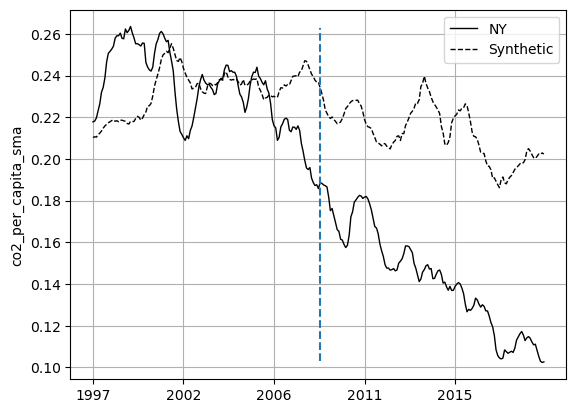

In [11]:
# Monthly_emissions SMA synthetic control plot

synth_mo_ma.path_plot(time_period=years_sma, treatment_time=treatment_dates_ma[0])

In [12]:
synth_mo_ma.summary()

,V,treated,synthetic,sample mean
co2_per_capita_sma,1.0,0.233,0.233,1.011
